# Extract values to be able to synchronise Miniscope, webcam and ephys.

Webcam not synchronised at the moment because there is no conflict between OE_miniscope and miniscope timestamps. 

Load the required packages (and many more that are not useful)

In [19]:
#%reset

import numpy as np
import csv
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt



Import the files

In [20]:
folderGen = Path('.').absolute()
Fold1 = 'Gaelle'
recording = 'Baseline_recording'
mouse_name = 'GreenDotsOK'
Rec = 'session1'
AcqFre = 30 # frames / sec
delaystampMini = (1000/AcqFre)*1.5
delaystampOE = (25000/AcqFre)*1.5*2

#date = '2022_03_14'
#device = 'MiniscopeCamera'
#time = '13_37_24'
folderMouse = Path(f'{folderGen}/{Fold1}/{recording}/{mouse_name}/{Rec}/')


for file_path in folderMouse.glob('**/*timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)
    elif subfolder == 'WebCam':
        stamps_webcam = pd.read_csv(file_path)
# Warning, here I a have moved the OpenEphys file to the video folder. To determine what is the most efficient strategy
for file_path in folderMouse.glob('**/*.npy'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'TTL':
        file = file_path.stem
        stamps_OEmini = np.load(file_path)
        datalen = len(stamps_OEmini)
        coords = {
            'recordings' : np.array(['full_words', 'timestamps', 'channel_states', 'channels']),
            'duration_rec' : np.arange(datalen)
        }
        Allstamps = xr.DataArray(coords=coords, dims=['recordings', 'duration_rec'])

for file_path in folderMouse.glob('**/*.npy'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'TTL':
        file = file_path.stem
        stamps_OEmini = np.load(file_path)
        Allstamps.loc[file,:] = stamps_OEmini

folder_Ephys = folderMouse / f'OpenEphys/'
#filenameE = folder_Ephys / f'timestamps.npy'
#stamps_OEOE = np.load(filenameE)


#Allstamps.shape

Plot the different timestamps files. 
Not a necessary step unless there is doubt about the data quality

range(0, 55163)


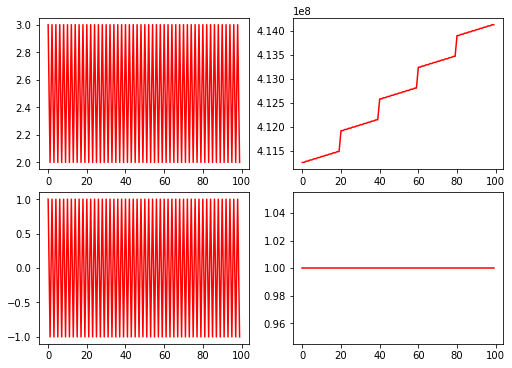

In [21]:
time = range(datalen)
print(time)
fullwords = Allstamps.loc['full_words',:].values
timestamps = Allstamps.loc['timestamps',:].values
channelstates = Allstamps.loc['channel_states',:]
channels = Allstamps.loc['channels',:]

debut = 0
fin = 100
timeTrunc = time[debut:fin]
fullwordsTrunc = fullwords[debut:fin]
timestampsTrunc = timestamps[debut:fin]
channelstatesTrunc = channelstates[debut:fin]
channelsTrunc = channels[debut:fin]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(7,5), layout='constrained') 
ax1.plot(timeTrunc, fullwordsTrunc, 'r')
ax2.plot(timeTrunc, timestampsTrunc, 'r')
ax3.plot(timeTrunc, channelstatesTrunc, 'r')
ax4.plot(timeTrunc, channelsTrunc, 'r')



Compute the delta between each time stamp in the miniscope timestamp file, this allows for determining if and when a frame was dropped.

In [22]:
stamps_miniscope_time = stamps_miniscope['Time Stamp (ms)']
delay_stamps = []
dropped_frames = []
number_frames = stamps_miniscope['Time Stamp (ms)'].count()
for i in range(number_frames -1):
    delay_stamps.append(stamps_miniscope_time[i+1] - stamps_miniscope_time[i])
    if delay_stamps[i] > delaystampMini:
        dropped_frames.append(i)

freq_acq = round(1000/(sum(delay_stamps)/len(delay_stamps)))
dropped_frames


[5662,
 19344,
 21984,
 23815,
 26005,
 26006,
 26442,
 26443,
 26444,
 28208,
 30397,
 32590,
 32593,
 34798,
 38099,
 38100,
 39209,
 39211,
 41418,
 43639,
 43641,
 48064,
 48065,
 48066,
 50146,
 50251,
 51870,
 52469,
 52472]

From the xarray that summarises all the timestamps (laser and miniscope) received as TTL by OpenEphys, we extract the timestamps that correspond to either laser or miniscope.

In [23]:
OE_stamps_miniscope = []
OE_stamps_laser = []

for i in range(datalen):
    if channels[i] == 2:
        OE_stamps_miniscope.append(timestamps[i])
    elif channels[i] == 1:
        OE_stamps_laser.append(timestamps[i])

len(OE_stamps_miniscope)

53683

Plot to make sure the right stamps have been rightly distributed to the appropriate list.

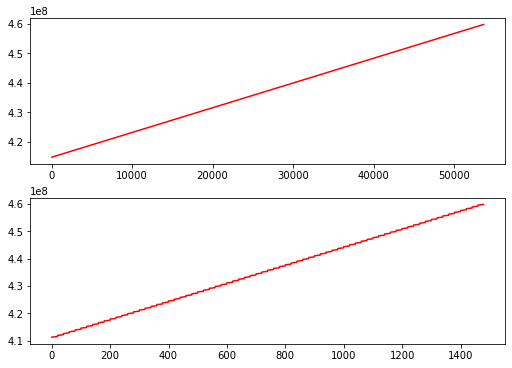

In [24]:
time1 = range(len(OE_stamps_miniscope))
time2 = range(len(OE_stamps_laser))

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,5), layout='constrained') 
ax1.plot(time1, OE_stamps_miniscope, 'r')
ax2.plot(time2, OE_stamps_laser, 'r')

Determine if I can see dropped frames in OE

In [25]:
time1 = range(len(OE_stamps_miniscope)-2)
delay_stamps = []
for i in time1:
    delay_stamps.append(OE_stamps_miniscope[i+2] - OE_stamps_miniscope[i])
    if delay_stamps[i] > delaystampOE:
        print(delay_stamps[i], i)



2515.0 21981
2518.0 21982


Normalise time stamps from open ephys signal.
two steps
- remove initial timing by extracting software 0ing from .txt file
- to get time in ms and not in acquisition point (acq rate = 25 kHz)
- for laser, get one value per laser flash

In [26]:
A = []
for file_path in folderMouse.glob('**/*sync_messages.txt'):
    with open(file_path, "r") as f:
        lines = f.readlines()
    # Loop through all lines, ignoring header.
    # take last element to list (i.e. the process name)
        for l in lines[1:]:
            A.append(l.split()[-1])

# remove acquisition frequency that is normally always 25 kHz
#initial_OE_start = int(''.join([x.strip('@25000Hz') for x in A]))
initial_OE_start = 411044352#stamps_OEOE[0]
# transform in pd series for easier manipulation
B = pd.Series(OE_stamps_miniscope)
C = pd.Series(OE_stamps_laser)

# normalise to ms
OE_stamps_miniscope_n = (B - initial_OE_start)/25000
OE_stamps_laser_inter = (C - initial_OE_start)/25000

# take only the middle of the laser pulse
OE_stamps_laser_n = [] 
for i in range(len(OE_stamps_laser_n) - 1):
    if (OE_stamps_laser_n[i+1] - OE_stamps_laser_n[i]) < 30:
        interm = OE_stamps_laser_n[i] + 10
        OE_stamps_laser_n.append(interm)



Last, extract important values for the next steps
- start acquisition time for Ca2+ relative to OE internal time and to time zeroed.
- acquisition frequency for Ca2+ imaging
- dropped frame timing

In [27]:
# _n is from 0
acquisition_mini_start_n = OE_stamps_miniscope_n[0]
# _a is from acquisition time software
acquisition_mini_start_a = B[0]
# freq_acq in Hz
freq_acq
# list of dropped frames from miniscope
dropped_frames

outSumm = pd.Series([acquisition_mini_start_n, acquisition_mini_start_a, freq_acq, dropped_frames],
              index=['Miniscope start from 0', 'Miniscope start from Acq time soft', 'mini acq freq', 'dropped frames'])


filenameOut = folderMouse / f'SynchroFile.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.save()

        

In [28]:
outSumm

Miniscope start from 0                                                        148.95256
Miniscope start from Acq time soft                                          414768166.0
mini acq freq                                                                        30
dropped frames                        [5662, 19344, 21984, 23815, 26005, 26006, 2644...
dtype: object